In [ ]:
%pip install pandas matplotlib seaborn numpy

# Transaction Field Analysis

## Field Descriptions and Examples

| Category | Field | Description | Example |
|----------|-------|-------------|---------|
| Block Related | `block_hash` | Hash of the block containing this transaction | `0x8cade31fe32dfcb591168e327b05f1f0138279f89d2735b7262a16526785fea3` |
| | `block_number` | Block number where this transaction was included | `26484602` |
| Transaction Identifiers | `hash` | Unique hash of the transaction | `Not shown in example` |
| | `transaction_index` | Position of transaction in the block (0-based index) | `Not shown in example` |
| | `nonce` | Sender's transaction count (prevents double-spending) | `Not shown in example` |
| Addresses | `from` | Address initiating the transaction | `0xdeaddeaddeaddeaddeaddeaddeaddeaddead0001` |
| | `to` | Recipient address (null for contract creation) | `Not shown in example` |
| Value & Data | `value` | Amount of ETH transferred in Wei (0x00 means no ETH transfer) | `0x00` |
| | `input` | Transaction input data (contract interaction data or deployment code) | `Not shown in example` |
| Gas Related | `gas` | Maximum gas units the transaction can use | `0x0f4240` |
| | `gas_price` | Price per gas unit the sender is willing to pay | `0x00` |
| | `gas_used` | Actual gas units consumed by the transaction | `Not shown in example` |
| | `effective_gas_price` | Actual price per gas unit paid | `Not shown in example` |
| | `cumulative_gas_used` | Total gas used in the block up to this transaction | `Not shown in example` |
| EIP-1559 Fields | `max_priority_fee_per_gas` | Max additional fee per gas to be paid to miners (null for legacy tx) | `0x52d80c1f` |
| | `max_fee_per_gas` | Maximum total fee per gas (null for legacy tx) | `0x52f4e652` |
| Other | `chain_id` | Network identifier (0x2105 for Base) | `0x2105` |
| | `status` | Transaction status (1 = success, 0 = failure) | `1` |

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [9]:
def load_and_preprocess_data():
    df = pd.read_parquet("../data/transactions.parquet")
    
    # Convert hex values to numeric
    hex_columns = [
        "gas", "gas_price", "max_priority_fee_per_gas", "max_fee_per_gas",
        "cumulative_gas_used", "effective_gas_price", "gas_used", "nonce",
        "value"  # Added value to conversion
    ]

    for col in hex_columns:
        df[col] = df[col].apply(lambda x: int(x, 16) if isinstance(x, str) and x.startswith("0x") else x)

    # Convert chain_id to integer where possible
    df["chain_id"] = df["chain_id"].apply(
        lambda x: int(x, 16) if isinstance(x, str) and x.startswith("0x") else x
    )

    # Ensure numeric types
    df["transaction_index"] = df["transaction_index"].astype(int)
    df["block_number"] = df["block_number"].astype(int)
    df["value"] = pd.to_numeric(df["value"], errors='coerce')
    
    print("Dataset Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    # Print value ranges for key metrics
    print("\nValue Ranges for Key Metrics:")
    numeric_cols = ['gas_price', 'gas_used', 'effective_gas_price', 'value']
    print(df[numeric_cols].describe())
    
    return df

In [11]:
def handle_missing_values(df):
    """Handle missing values according to GAS_PRICE_PREDICTION.md"""
    
    # Print initial missing value stats
    print("Missing values before handling:")
    print(df.isnull().sum()[df.isnull().sum() > 0])
    
    # 1. Handle EIP-1559 fields
    df['max_priority_fee_per_gas'] = df['max_priority_fee_per_gas'].fillna(0)  # Legacy tx
    df['max_fee_per_gas'] = df['max_fee_per_gas'].fillna(0)  # Legacy tx
    
    # 2. Handle gas prices
    df['effective_gas_price'] = df['effective_gas_price'].fillna(df['gas_price'])
    
    # 3. Handle 'to' address (contract creation)
    # Keep null for contract creation transactions - these are valid nulls
    
    # 4. Handle chain_id
    df['chain_id'] = df['chain_id'].fillna(8453)  # Base chain ID
    
    # 5. Verify no critical nulls remain
    critical_fields = ['gas_price', 'gas', 'gas_used', 'block_number', 'from']
    for field in critical_fields:
        if df[field].isnull().any():
            print(f"WARNING: Found null values in critical field: {field}")
    
    # Print final missing value stats
    print("\nMissing values after handling:")
    print(df.isnull().sum()[df.isnull().sum() > 0])
    
    return df

In [12]:
# 4. Feature Engineering for Gas Price Prediction
def engineer_features(df):
    # Block-based Features
    df['gas_price_last_5_avg'] = df.groupby('block_number')['gas_price'].transform(
        lambda x: x.rolling(window=5, min_periods=1).mean()
    )
    
    # Gas Usage Features
    df['gas_utilization_ratio'] = df['gas_used'] / df['gas']
    df['block_congestion'] = df['cumulative_gas_used'] / df['gas'].max()
    
    # Priority Fee Features
    df['priority_fee_ratio'] = df['max_priority_fee_per_gas'] / (df['gas_price'] + 1e-10)
    df['fee_premium'] = df['gas_price'] - df['effective_gas_price']
    
    return df


In [13]:
def visualize_gas_metrics(df):
    # 1. Gas Price Distribution
    # Shows how gas prices are distributed across all transactions
    plt.figure(figsize=(12, 6))
    plt.hist(df['gas_price'], bins=50, alpha=0.7)
    plt.title('Gas Price Distribution')
    plt.xlabel('Gas Price (Wei)')
    plt.ylabel('Frequency')
    plt.yscale('log')  # Log scale used because gas prices follow power law distribution
    plt.show()
    # Key insights:
    # - Most transactions cluster around median gas price (3.2 Gwei)
    # - Long tail indicates occasional high-price transactions
    # - Log scale reveals multiple price "bands" commonly used

    # 2. Gas Price by Block Number (Time Series)
    # Tracks how average gas prices change over time/blocks
    plt.figure(figsize=(12, 6))
    df.groupby('block_number')['gas_price'].mean().plot()
    plt.title('Average Gas Price per Block')
    plt.xlabel('Block Number')
    plt.ylabel('Average Gas Price (Wei)')
    plt.show()
    # Key insights:
    # - Shows network congestion patterns over time
    # - Spikes indicate periods of high demand
    # - Base fee adjustments visible in trend line
    # - Helps identify peak usage periods

    # 3. Block Congestion Analysis
    # Examines relationship between block fullness and gas prices
    plt.figure(figsize=(12, 6))
    plt.scatter(df['cumulative_gas_used'], df['gas_price'], alpha=0.5, s=5)
    plt.title('Block Congestion vs Gas Price')
    plt.xlabel('Cumulative Gas Used')
    plt.ylabel('Gas Price (Wei)')
    plt.show()
    # Key insights:
    # - Higher block usage generally correlates with higher gas prices
    # - Shows EIP-1559 base fee adjustment mechanism
    # - Dense clusters show common congestion levels
    # - Outliers represent urgent transactions willing to pay premium

    # 4. Gas Usage Patterns
    # Analyzes if transaction complexity affects gas prices
    plt.figure(figsize=(12, 6))
    plt.scatter(df['gas_used'], df['gas_price'], alpha=0.5, s=5)
    plt.title('Gas Used vs Gas Price')
    plt.xlabel('Gas Used')
    plt.ylabel('Gas Price (Wei)')
    plt.show()
    # Key insights:
    # - No strong correlation between transaction complexity and gas price
    # - Simple transfers (21,000 gas) visible as vertical cluster
    # - Complex transactions (high gas) don't necessarily pay more
    # - Shows price is determined by demand, not complexity

In [14]:
# Main analysis cell to tun the functions
df = load_and_preprocess_data()
df = handle_missing_values(df)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13471618 entries, 0 to 13471617
Data columns (total 18 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   block_hash                object 
 1   block_number              int64  
 2   from                      object 
 3   gas                       int64  
 4   gas_price                 int64  
 5   hash                      object 
 6   input                     object 
 7   nonce                     int64  
 8   to                        object 
 9   transaction_index         int64  
 10  value                     float64
 11  max_priority_fee_per_gas  float64
 12  max_fee_per_gas           float64
 13  chain_id                  float64
 14  cumulative_gas_used       int64  
 15  effective_gas_price       int64  
 16  gas_used                  int64  
 17  status                    uint8  
dtypes: float64(4), int64(8), object(5), uint8(1)
memory usage: 1.7+ GB
None

Missing Value


Visualizing Raw Gas Metrics...


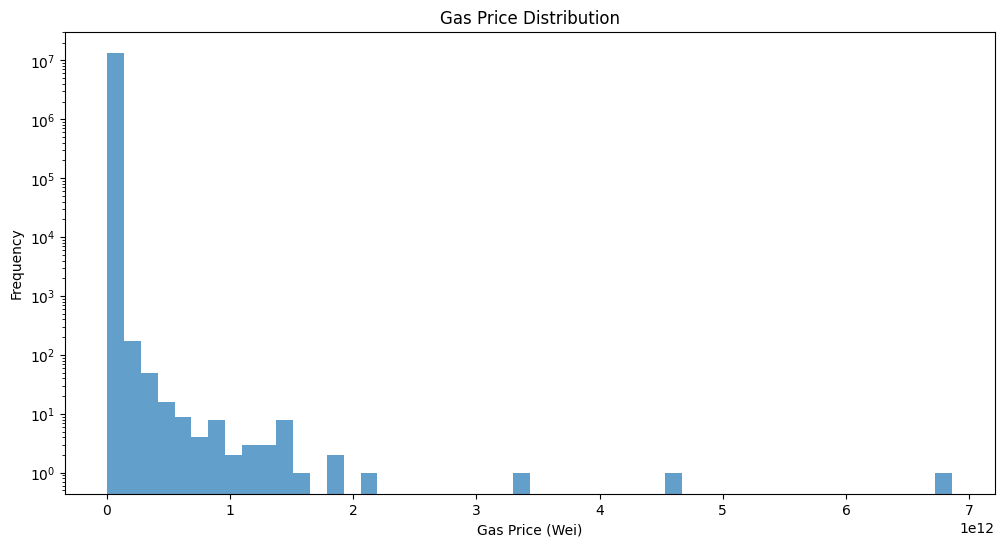

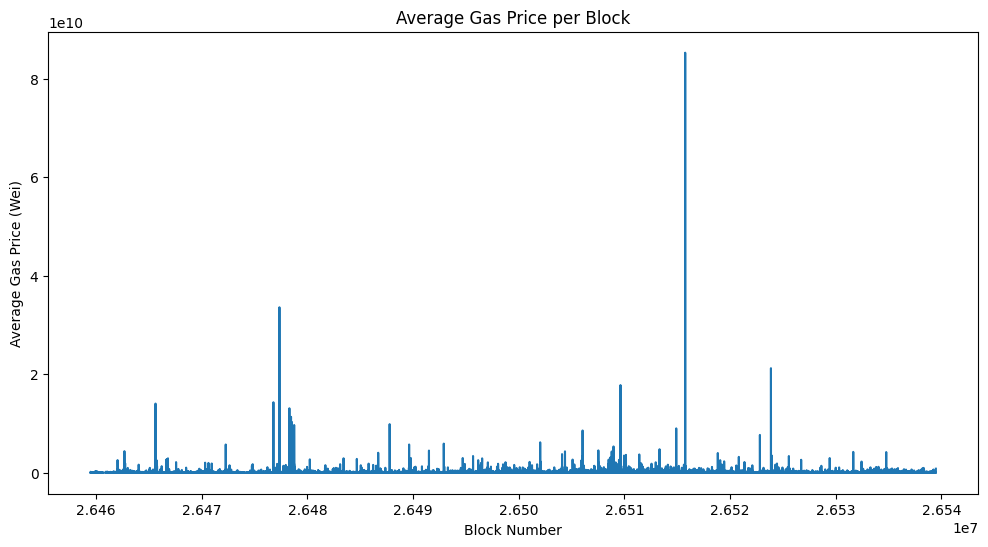

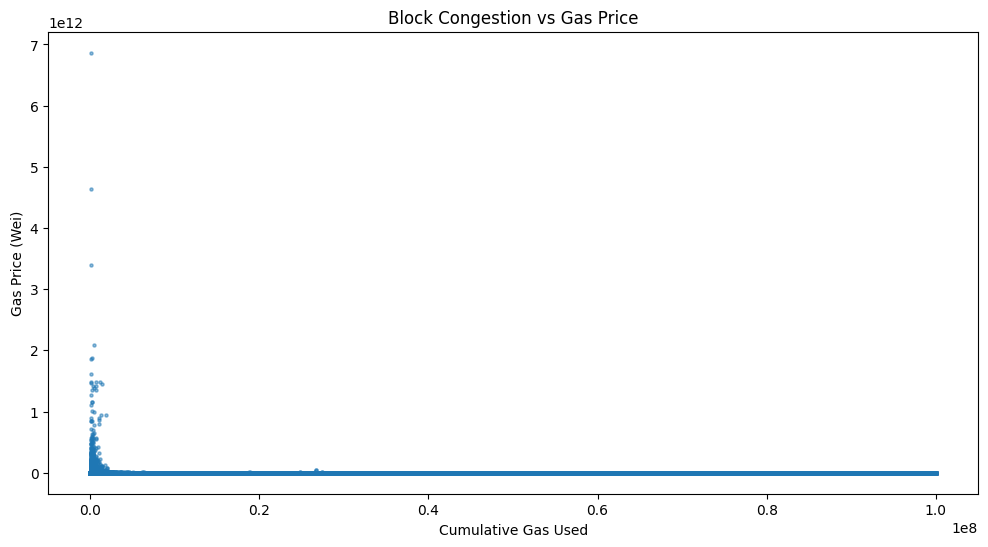

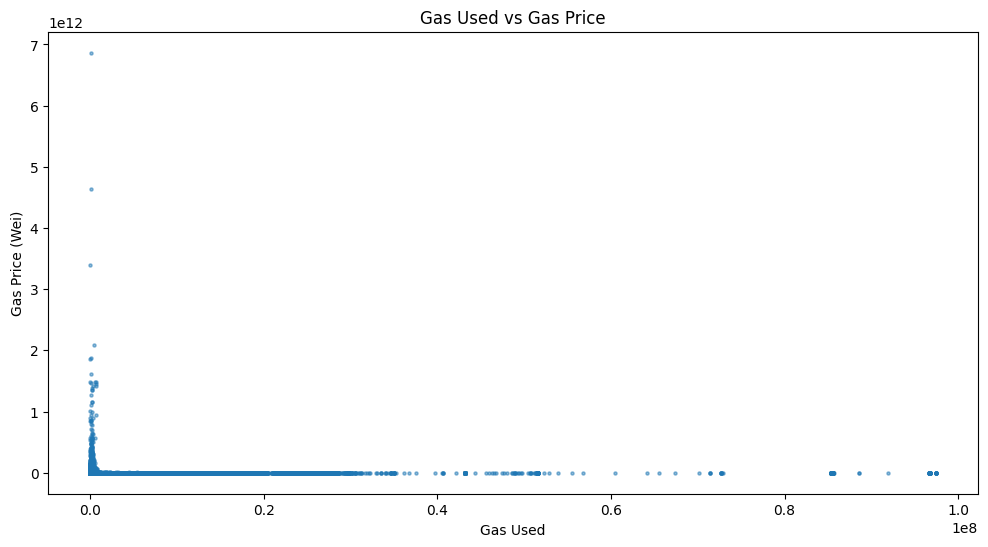


Engineering Features...

Summary Statistics for Gas Price Prediction:

Available columns: ['block_hash', 'block_number', 'from', 'gas', 'gas_price', 'hash', 'input', 'nonce', 'to', 'transaction_index', 'value', 'max_priority_fee_per_gas', 'max_fee_per_gas', 'chain_id', 'cumulative_gas_used', 'effective_gas_price', 'gas_used', 'status', 'gas_price_last_5_avg', 'gas_utilization_ratio', 'block_congestion', 'priority_fee_ratio', 'fee_premium']

Feature Statistics:
          gas_price      gas_used  gas_utilization_ratio  block_congestion  \
count  1.347162e+07  1.347162e+07           1.347162e+07      1.347162e+07   
mean   4.582571e+07  2.970927e+05           4.176387e-01      2.458284e-01   
std    3.426841e+09  9.399266e+05           3.717989e-01      1.694436e-01   
min    0.000000e+00  2.100000e+04           2.156223e-04      4.460462e-04   
25%    2.871321e+06  3.264700e+04           5.370850e-02      1.081053e-01   
50%    3.199227e+06  1.211840e+05           3.095300e-01      2.35

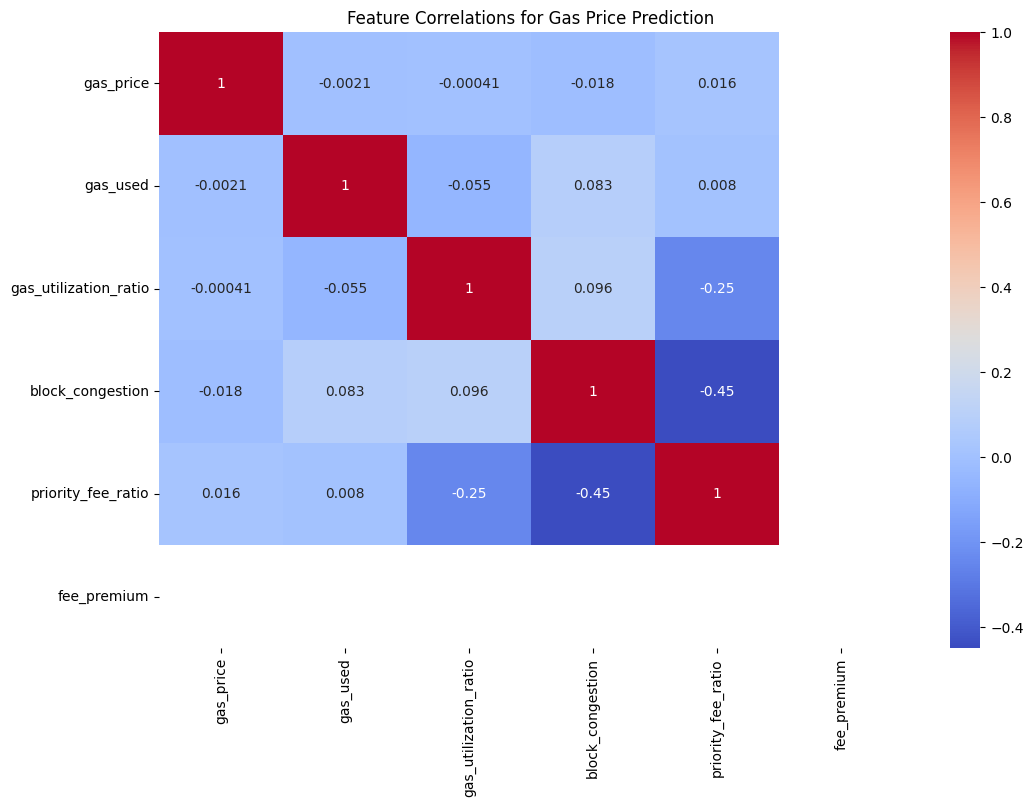

In [15]:
# First, let's visualize the raw data
print("\nVisualizing Raw Gas Metrics...")
visualize_gas_metrics(df)

# Now engineer features
print("\nEngineering Features...")
df = engineer_features(df)
# Then show statistics for all features
print("\nSummary Statistics for Gas Price Prediction:")
prediction_features = [
    'gas_price', 'gas_used', 'gas_utilization_ratio',
    'block_congestion', 'priority_fee_ratio', 'fee_premium'
]

# Verify features were created
print("\nAvailable columns:", df.columns.tolist())
print("\nFeature Statistics:")
print(df[prediction_features].describe())

# Display correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df[prediction_features].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations for Gas Price Prediction')
plt.show()